# House prices prediction

Link on competition dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques



# Imports

In [72]:
import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [73]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [74]:
os.get_

AttributeError: module 'os' has no attribute 'get_'

In [77]:
# Commonly used constants and paths
SEED = 42
DATA_PATH = "Data"
TRAIN_PATH = f'{DATA_PATH}/train.csv'
TEST_PATH = f'{DATA_PATH}/test.csv'
DESCRIPTION = f'{DATA_PATH}/data_description.txt'
TARGET = 'SalePrice'
NAN_CATEGORY = '<NAN>'

# Functions

In [78]:
def univariate_regplot(x, y, data):
    ax = sns.regplot(x=x, y=y, data=train)
    ax.set_title(f'{y} and {x} relationship')
    return ax

# Contents:  
1. **gradient descend**  
Basic step of every machine learning training pipeline.  
Literally it is a *learning* step  
2. **train/test split + cross validation** (kfold, timeseries split)  
train - to fit model,   
validation - to tune hyperparameters,  
test - to get final score, assess generalization power of model, find under/over- fitting  
3. **regression problem / model trainig pipeline in sklearn** 
sklearn model interface  
prepare data -> get model instance -> choose metric and loss function -> fit on train -> predict on test -> get final score -> repeat if nessesary  
4. **metrics**   
5. **regularization** 
6. **grid search** 

# Gradient descend

In [79]:
# m denotes the number of examples here, not the number of features
def gradientDescent(x, y, theta, alpha, m, num_iterations):
    """
    run gradient descent cycle 

    x - train data
    y - target
    theta - initial parameter estimations
    alpha - learning rate
    m - number of examples in x
    """
    xTrans = x.transpose()
    history = []
    for i in range(0, num_iterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        # avg cost per example (the 2 in 2*m doesn't really matter here.
        # But to be consistent with the gradient, I include it)
        cost = np.sum(loss ** 2) / (2 * m)
        if i%1000 == 0:
            print(f"Iteration {i} | Cost: {cost} | Theta: {theta}")
        if i==num_iterations-1:
            print(f"Loss on final step: {cost} | Theta: {theta}")
        # avg gradient per example

        gradient = np.dot(xTrans, loss) / m
        # update
        theta = theta - alpha * gradient
        #log history
        history.append({'cost':cost,'theta':theta})
    return theta, history


def genData(numPoints, intercept, slope, variance):
    """
    generate syntetic dataset
    
    numPoints - number of observations in generated dataset
    intercept, slope - ground truth parameters of equation
    variance - synthetic noize value
    """
    x = np.zeros(shape=(numPoints, 2))
    y = np.zeros(shape=numPoints)
    # basically a straight line
    for i in range(0, numPoints):
        # bias feature
        x[i][0] = 1
        x[i][1] = i
        # our target variable
        y[i] = (slope * i + intercept) + random.uniform(-1, 1) * variance
    return x, y

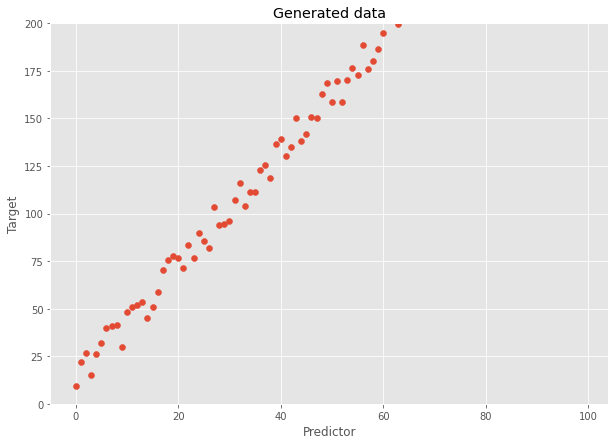

In [80]:
# gen 100 points with a bias of 25 and 10 variance as a bit of noise
x, y = genData(100, 12.4, 3, 10)
plt.scatter(x[:,1],y);
plt.ylim([0,200]);
plt.title('Generated data');
plt.ylabel('Target');
plt.xlabel('Predictor');

In [81]:
m, n = np.shape(x)
numIterations= 50000
alpha = 0.0005
theta_initial = np.ones(n)
theta, history = gradientDescent(x, y, theta_initial, alpha, m, numIterations)
print(theta)

Iteration 0 | Cost: 7767.760940252041 | Theta: [1. 1.]
Iteration 1000 | Cost: 31.789290793574743 | Theta: [2.53915685 3.14687759]
Iteration 2000 | Cost: 28.26234805132642 | Theta: [3.86611634 3.12687163]
Iteration 3000 | Cost: 25.52578124678343 | Theta: [5.03497362 3.1092493 ]
Iteration 4000 | Cost: 23.402469805965165 | Theta: [6.06456598 3.09372661]
Iteration 5000 | Cost: 21.75498527636218 | Theta: [6.9714863  3.08005339]
Iteration 6000 | Cost: 20.476696456783625 | Theta: [7.77035049 3.06800928]
Iteration 7000 | Cost: 19.484867837516823 | Theta: [8.47403303 3.05740018]
Iteration 8000 | Cost: 18.715304656700607 | Theta: [9.09387446 3.04805511]
Iteration 9000 | Cost: 18.118197981450884 | Theta: [9.63986412 3.03982348]
Iteration 10000 | Cost: 17.654900892250662 | Theta: [10.12080118  3.03257261]
Iteration 11000 | Cost: 17.29542711351319 | Theta: [10.54443641  3.02618565]
Iteration 12000 | Cost: 17.016510192573993 | Theta: [10.9175971   3.02055968]
Iteration 13000 | Cost: 16.8000976101057

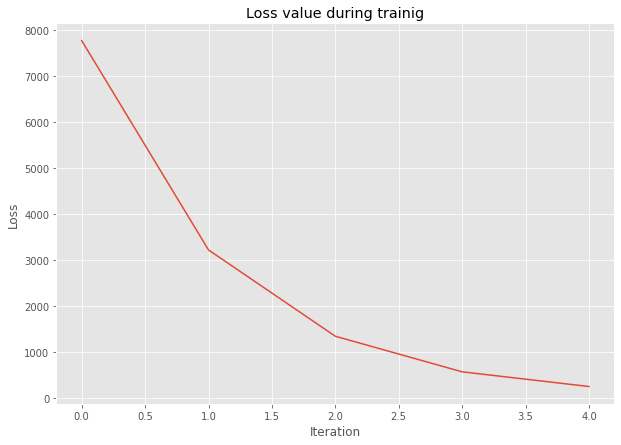

In [82]:
plt.plot(list(map(lambda x: x['cost'], history))[:5]);
plt.ylabel('Loss');
plt.xlabel('Iteration');
plt.title('Loss value during trainig');

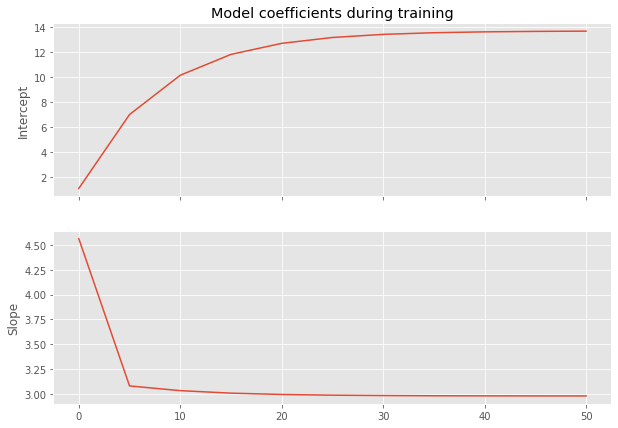

In [83]:
intercepts = list(map(lambda x: x['theta'][0], history))
slopes = list(map(lambda x: x['theta'][1], history))

intercepts = [intercepts[i] for i in range(len(intercepts)) if i%5000==0 or i==0 or i==len(intercepts)-1]
slopes = [slopes[i] for i in range(len(slopes)) if i%5000==0 or i==0 or i==len(slopes)-1]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True);
ax1.set_title('Model coefficients during training');
ax1.plot(intercepts);
ax1.set_ylabel('Intercept');

ax2.plot(slopes);
ax2.set_ylabel('Slope');
ax2.set_xticklabels(['0','0','10','20','30','40','50']);

In [84]:
(list(map(lambda x: x[1], x)), y)

([0.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0,
  26.0,
  27.0,
  28.0,
  29.0,
  30.0,
  31.0,
  32.0,
  33.0,
  34.0,
  35.0,
  36.0,
  37.0,
  38.0,
  39.0,
  40.0,
  41.0,
  42.0,
  43.0,
  44.0,
  45.0,
  46.0,
  47.0,
  48.0,
  49.0,
  50.0,
  51.0,
  52.0,
  53.0,
  54.0,
  55.0,
  56.0,
  57.0,
  58.0,
  59.0,
  60.0,
  61.0,
  62.0,
  63.0,
  64.0,
  65.0,
  66.0,
  67.0,
  68.0,
  69.0,
  70.0,
  71.0,
  72.0,
  73.0,
  74.0,
  75.0,
  76.0,
  77.0,
  78.0,
  79.0,
  80.0,
  81.0,
  82.0,
  83.0,
  84.0,
  85.0,
  86.0,
  87.0,
  88.0,
  89.0,
  90.0,
  91.0,
  92.0,
  93.0,
  94.0,
  95.0,
  96.0,
  97.0,
  98.0,
  99.0],
 array([  9.09291582,  21.81005152,  26.71803128,  15.32945869,
         26.19299379,  32.01138523,  39.64940819,  41.12358023,
         41.55185413,  30.09074732,  48.50581061,  51.06238915,
         52.18950

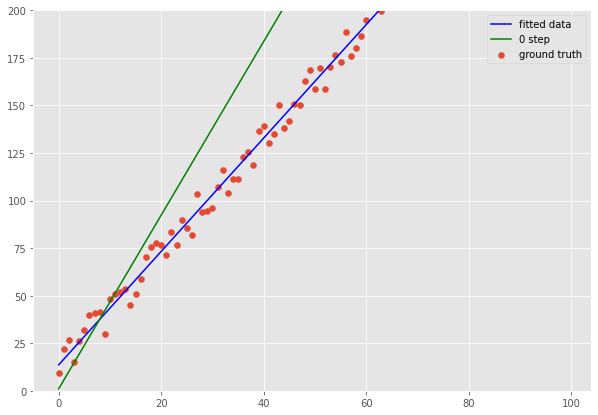

In [85]:
plt.scatter(list(map(lambda x: x[1], x)), y);

plt.plot(np.dot(x, theta), 'blue');
plt.plot(np.dot(x, history[0]['theta']),'green');

plt.legend(['fitted data', '0 step', 'ground truth']);
plt.ylim([0,200]);

## Loss function vs Quality metric

**Loss function** - always differentiable. Used by model to tune parameters.   Doesn't have meaningful interpretation. Varies from 0 to Inf.  
**Quality metric** - not always differentiable. Used by scientist. Has interpetation (fraction of right answers, mean difference between GT and predicted values)

In [86]:
ev_1 = metrics.explained_variance_score(y, np.dot(x, history[0]['theta']))
ev_final = metrics.explained_variance_score(y, np.dot(x, theta))

pd.DataFrame.from_dict({'first iteration':ev_1, 'last iteration':ev_final}, 
                          orient='index',
                          columns=['Explained variance'])

,Explained variance
first iteration,0.714256
last iteration,0.995677


# How everything works in sklearn

## EDA

### Download&overview

In [87]:
train = pd.read_csv(TRAIN_PATH, index_col=0)
test = pd.read_csv(TEST_PATH, index_col=0)
full_house = pd.concat([train, test], sort=False)
full_house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [88]:
full_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [89]:
with open(DESCRIPTION, 'r') as f:
   info = f.read()
print(info)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [90]:
# categories described as numbers
mssubclass_mapping = {
    20: '1-STORY 1946 & NEWER ALL STYLES',
    30: '1-STORY 1945 & OLDER',
    40: '1-STORY W/FINISHED ATTIC ALL AGES',
    45: '1-1/2 STORY - UNFINISHED ALL AGES',
    50: '1-1/2 STORY FINISHED ALL AGES',
    60: '2-STORY 1946 & NEWER',
    70: '2-STORY 1945 & OLDER',
    75: '2-1/2 STORY ALL AGES',
    80: 'SPLIT OR MULTI-LEVEL',
    85: 'SPLIT FOYER',
    90: 'DUPLEX - ALL STYLES AND AGES',
   120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
   150: '1-1/2 STORY PUD - ALL AGES',
   160: '2-STORY PUD - 1946 & NEWER',
   180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
   190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
}
mosold_mapping = dict(zip(range(1, 13), ['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 
                                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

full_house.loc[:, 'MSSubClass'] = full_house.MSSubClass.map(mssubclass_mapping)
full_house.loc[:, 'MoSold'] = full_house.MoSold.map(mosold_mapping)

full_house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,2-STORY 1946 & NEWER,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,Feb,2008,WD,Normal,208500.0
2,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,May,2007,WD,Normal,181500.0
3,2-STORY 1946 & NEWER,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,Sep,2008,WD,Normal,223500.0
4,2-STORY 1945 & OLDER,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,Feb,2006,WD,Abnorml,140000.0
5,2-STORY 1946 & NEWER,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,Dec,2008,WD,Normal,250000.0


In [91]:
# Categories with implied ordering
full_house.loc[:, 'KitchenQual'] = pd.Categorical(full_house.KitchenQual, ordered=True, categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'])
full_house.loc[:, 'OverallQual'] = pd.Categorical(full_house.OverallQual, ordered=True)
full_house.loc[:, 'OverallCond'] = pd.Categorical(full_house.OverallQual, ordered=True)
full_house.loc[:, 'YearBuilt'] = pd.Categorical(full_house.YearBuilt, ordered=True)
full_house.loc[:, 'YearRemodAdd'] = pd.Categorical(full_house.YearRemodAdd, ordered=True)
full_house.loc[:, 'MoSold'] = pd.Categorical(full_house.MoSold, ordered=True)
full_house.loc[:, 'YrSold'] = pd.Categorical(full_house.YrSold, ordered=True)
full_house.loc[:, 'GarageYrBlt'] = pd.Categorical(full_house.GarageYrBlt, ordered=True)

In [92]:
full_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     2919 non-null   object  
 1   MSZoning       2915 non-null   object  
 2   LotFrontage    2433 non-null   float64 
 3   LotArea        2919 non-null   int64   
 4   Street         2919 non-null   object  
 5   Alley          198 non-null    object  
 6   LotShape       2919 non-null   object  
 7   LandContour    2919 non-null   object  
 8   Utilities      2917 non-null   object  
 9   LotConfig      2919 non-null   object  
 10  LandSlope      2919 non-null   object  
 11  Neighborhood   2919 non-null   object  
 12  Condition1     2919 non-null   object  
 13  Condition2     2919 non-null   object  
 14  BldgType       2919 non-null   object  
 15  HouseStyle     2919 non-null   object  
 16  OverallQual    2919 non-null   category
 17  OverallCond    2919 non-null   ca

### Target variable analysis

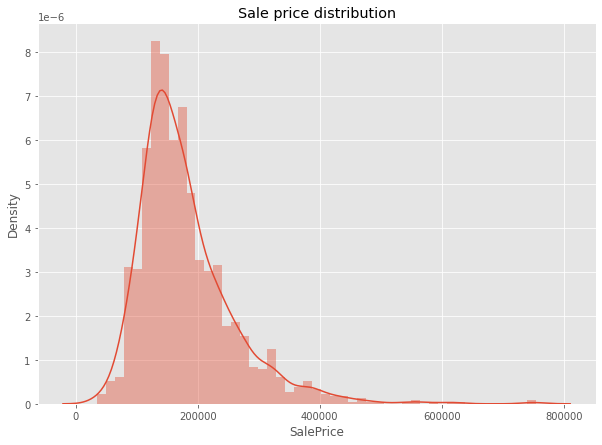

In [93]:
ax = sns.distplot(train.SalePrice, norm_hist=True)
ax.set_title('Sale price distribution');

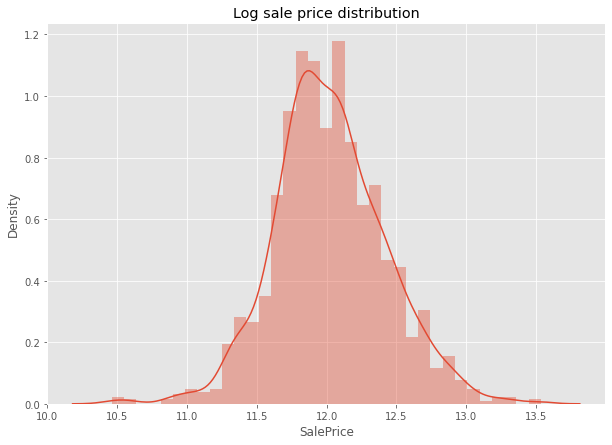

In [94]:
ax = sns.distplot(np.log(train.SalePrice), norm_hist=True)
ax.set_title('Log sale price distribution');

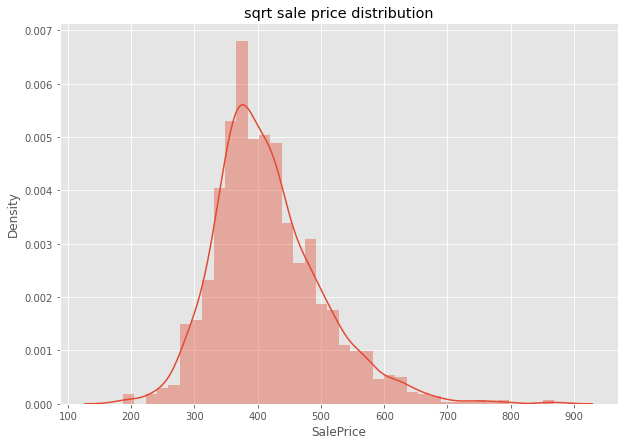

In [95]:
ax = sns.distplot(np.sqrt(train.SalePrice), norm_hist=True)
ax.set_title('sqrt sale price distribution');

### Top correlated features

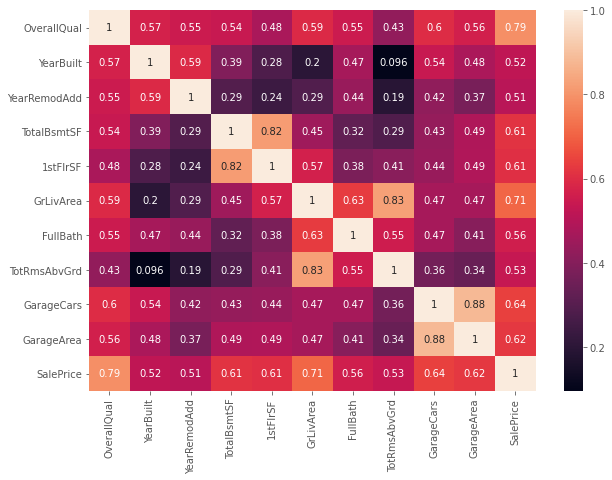

In [96]:
corr = train.corr()
condition = np.abs(corr.SalePrice) > 0.5
top_corr = corr.loc[condition, condition]
sns.heatmap(top_corr, annot=True);

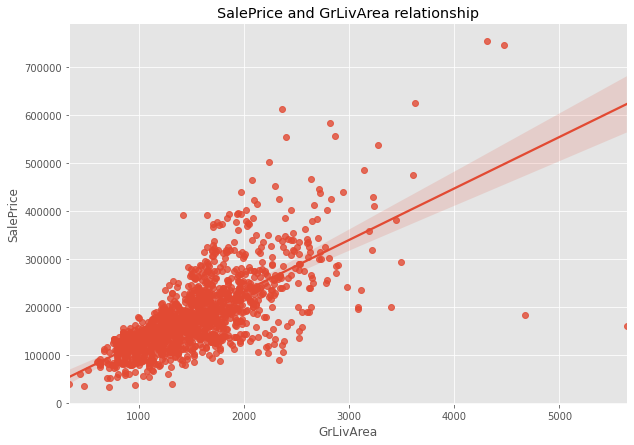

In [97]:
univariate_regplot('GrLivArea', 'SalePrice', train);

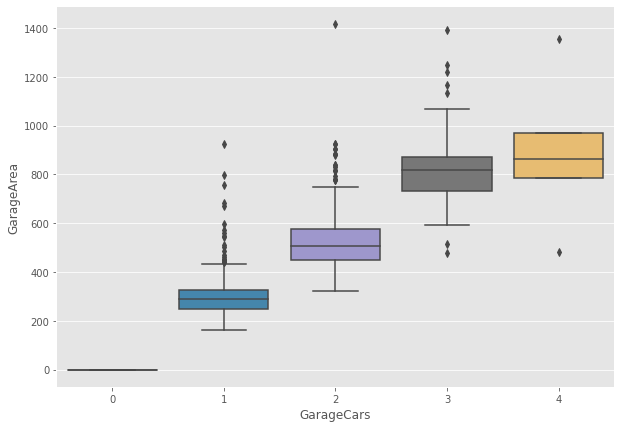

In [98]:
sns.boxplot(y='GarageArea', x='GarageCars', data=train);

# Pipeline

## Preprocessing

### Features categorization

In [99]:
CATEGORICAL = full_house.select_dtypes(include=['object']).columns.tolist()
ORDINAL = full_house.select_dtypes(include=['category']).columns.tolist()
NUMERICAL = full_house.select_dtypes(exclude=['category', 'object']).columns.tolist()
if TARGET in NUMERICAL:
    NUMERICAL.remove(TARGET)

In [100]:
# Apply encoding to ordinal values, .cat.categories - decoding
full_house[ORDINAL] = full_house[ORDINAL].apply(lambda x: x.cat.codes)

In [144]:
train = full_house.loc[full_house.SalePrice.notnull()]
test = full_house.loc[full_house.SalePrice.isnull()]

In [155]:
full_house[full_house.SalePrice < 20000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,


### Remove obvious outliers

In [150]:
outliers_ind = ((train.SalePrice < 20000) & (train.GrLivArea > 4000))
train = train.loc[~outliers_ind]

## Split

![](https://www.brainstobytes.com/content/images/2020/01/Sets.png)

Every time we are fitting machine learning model we need to know if it works well on new data it haven't seen before.
That's why we use **TRAIN** dataset (X and y) for tuning model parameters and **TEST** dataset to calculate model performance metrics

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Important parameters:  
*train size/test size* - float from 0 to 1 as proportion of data going to either dataset. 
train size + test size = 1 (!)  
*stratify* - boolean. Valid for classification tasks. If **True** - proportions of target classes in train and test dataset

basic interface:  
train_test_split(X, y)

In [151]:
target = train[TARGET].values
train_X, val_X, train_y, val_y = train_test_split(train.drop(TARGET, axis=1), target, 
                                                  random_state=SEED, shuffle=True, test_size = 0.2)

## Transformation

In [104]:
# Imputing missing values

# Numerical
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'median'},
        {'class': StandardScaler}
    ]
)

# Ordinal
ordinal_def = gen_features(
    columns=[[c] for c in ORDINAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'}
    ]
)

# Categorical
categorical_def = gen_features(
    columns=[[c] for c in CATEGORICAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'constant', 'fill_value': 'Unknown'},
        {'class': OneHotEncoder, 'class': OneHotEncoder, 'handle_unknown': 'ignore'}
    ]    
)

In [105]:
full_house.shape

(2919, 80)

In [106]:
# 
features = numerical_def + categorical_def + ordinal_def
mapper = DataFrameMapper(features)
len(features)

79

In [194]:
features

[(['LotFrontage'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['LotArea'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['MasVnrArea'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['BsmtFinSF1'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['BsmtFinSF2'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['BsmtUnfSF'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['TotalBsmtSF'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['1stFlrSF'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['2ndFlrSF'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['LowQualFinSF'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['GrLivArea'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['BsmtFullBath'], [SimpleImputer(strategy='median'), StandardScaler()], {}),
 (['BsmtHalfBath'], [SimpleImputer(strategy='median'), StandardScaler()], {}),


## Linear regression

### LR baseline

**Model interface in sklearn**

All model instances have more or less the same interface:  


```
model.fit(X_train, y_train)  
model.predict(X_test)  
model.score(X_test, y_test)
```


In [163]:
# One way
train_X_tr = pd.DataFrame(mapper.fit_transform(train_X))
val_X_tr = pd.DataFrame(mapper.transform(val_X))

# scaler = StandardScaler()
# scaler.fit(train_y.reshape(-1, 1))
# train_y_tr = scaler.transform(train_y.reshape(-1, 1))
# val_y_tr = scaler.transform(val_y.reshape(-1, 1))

train_y_tr = pd.Series(np.log(train_y))
val_y_tr = pd.Series(np.log(val_y))

In [164]:
linreg = LinearRegression()
linreg.fit(train_X_tr, train_y_tr)
print(f'\nR2 Score: {linreg.score(val_X_tr, val_y_tr)}')

LinearRegression()


R2 Score: -3.0929064770520476e+16


##### Score is VERY bad. Let's find examples where model is ridiculously wrong:

In [109]:
preds = linreg.predict(val_X_tr)
odd_idx = np.where( np.abs(preds)>20)[0]

In [175]:
preds[odd_idx]

array([ 7.05908727e+08, -9.80151100e+07,  7.05908727e+08,  7.05908728e+08,
       -6.72833597e+07, -2.82949252e+07,  4.18932301e+08])

In [186]:
#remove those points from dataset

valid_examples = [index for index in val_X_tr.index if index not in odd_idx]
print(val_X_tr.shape)
val_X_tr = val_X_tr.loc[valid_examples]
print(val_X_tr.shape)
val_y_tr = val_y_tr.loc[valid_examples]

(292, 313)
(285, 313)


In [187]:
#DO THE SAME WITH INITIAL DATA
val_X = val_X.iloc[valid_examples]
val_y = pd.Series(val_y).iloc[valid_examples]

In [113]:
print(f'\nR2 Score: {linreg.score(val_X_tr, val_y_tr)}')


R2 Score: 0.8664392065614019


In [114]:
#cross validation
def rmse(y_gt, Y_pr):
    return np.sqrt(mean_squared_error(y_gt, Y_pr))

print('RMSE val: ')
print(rmse(val_y_tr, linreg.predict(val_X_tr)))
print('-'*30)

rmse_scorer = metrics.make_scorer(rmse)
print('RMSE cross-validation scores:')
CV_score = cross_val_score(linreg, train_X_tr, train_y_tr, cv=5, scoring=rmse_scorer, )
print(CV_score)
print('-'*30)

print('RMSE average cross-validation scores:')
print(np.sum(CV_score)/5)
print('-'*30)

RMSE val: 
0.15744886907874958
------------------------------
RMSE cross-validation scores:
[4.62120940e+05 2.19162594e+07 1.43836710e-01 1.74579234e-01
 8.43896992e+06]
------------------------------
RMSE average cross-validation scores:
6163470.12282452
------------------------------


##### Self-Exercise:
figure out which of points in training data make scores THAT big

In [115]:
#metrics
predictions = linreg.predict(val_X_tr)

mae = metrics.mean_absolute_error(val_y_tr, predictions)
mse = metrics.mean_squared_error(val_y_tr, predictions)
r2 = metrics.r2_score(val_y_tr, predictions)
rmse = np.sqrt(metrics.mean_squared_error(val_y_tr, predictions))

pd.DataFrame.from_dict({'MAE':mae, 'MSE':mse, 'R2':r2, 'RMSE':rmse}, orient='index', columns=['Score'])

,Score
MAE,0.097579
MSE,0.024790
R2,0.866439
RMSE,0.157449


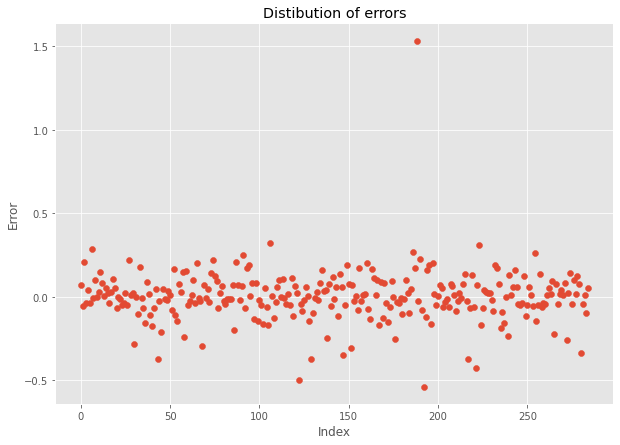

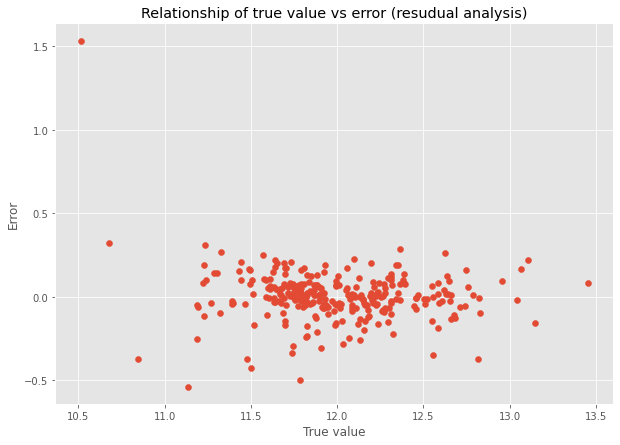

In [189]:
#errors visualization
#can be helpful to better understand behavior of model

pred = linreg.predict(val_X_tr)
errors = val_y_tr - pred

plt.scatter(list(range(len(errors))),errors);
plt.title("Distibution of errors")
plt.ylabel('Error');
plt.xlabel('Index');
plt.show();

plt.scatter(pred,errors);
plt.title('Relationship of true value vs error (resudual analysis)')
plt.ylabel('Error');
plt.xlabel('True value');
plt.show();

### Pipeline

In [190]:
# Evaluation

def evaluate_model(train, val, tr_y, val_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_val = pipeline.predict(val)
    pred_train = pipeline.predict(train)
    mapper = pipeline.named_steps['mapper']

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)]
    }), mapper.transformed_names_

In [191]:
# Cool way
pipeline = Pipeline([
    ('mapper', mapper),
    ('estimator', LinearRegression())
])

In [193]:
# Evaluate the same model using $\log(y)$ instead of $y$

pipeline = Pipeline([
    ('mapper', mapper),
    ('estimator', LinearRegression())
])
scores, _ = evaluate_model(train_X, val_X, train_y_tr, val_y_tr, pipeline)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.092958,0.943316,0.157449,0.866439


### Drop some features

Select only features that have a correlation coefficient with `SalePrice` more than 0.5. 

Remove from the list `GarageArea` feature as it is highly correlated with `GarageCars`

Filter currect feature_definition pipeline and fit the linear regression model only on top correlated features

In [120]:
ind = np.abs(corr[TARGET]) > 0.5
top_corr = corr[TARGET][ind].index.tolist()
top_corr.remove(TARGET)
top_corr.remove('GarageArea')

In [121]:
top_corr

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars']

In [122]:
top_corr_features = [f for f in features if f[0][0] in top_corr]
pipeline = Pipeline([
    ('mapper', DataFrameMapper(top_corr_features)),
    ('estimator', LinearRegression())
])

In [123]:
scores, _ = evaluate_model(train_X, val_X, train_y_tr, val_y_tr, pipeline)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.169546,0.811433,0.169801,0.844662


## Regularization

In [124]:
def plot_importance(est, colnames, top_n=20):
    importance = pd.DataFrame({
        'abs_weight': np.abs(est.coef_),
        'feature': colnames
    })
    imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
    sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h');

,train_RMSE,train_R2,val_RMSE,val_R2
0,19801.27124,0.934263,30709.758685,0.877968


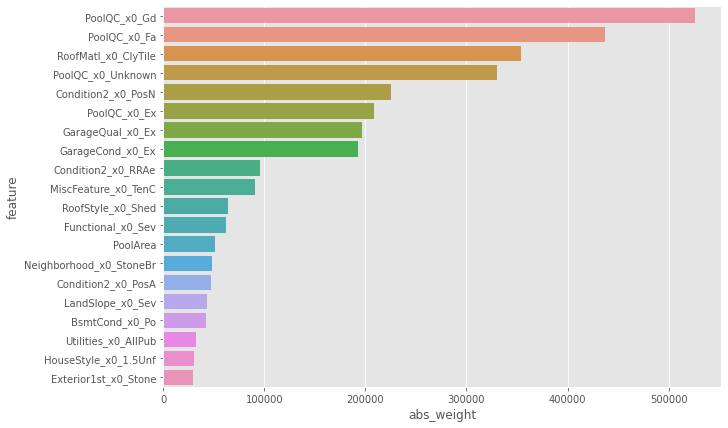

In [125]:
lasso = Lasso()
pipeline = Pipeline([('mapper', DataFrameMapper(features)), 
                     ('estimator', lasso)])

scores, colnames = evaluate_model(train_X, val_X, train_y, val_y, pipeline)
scores

plot_importance(pipeline.named_steps['estimator'], colnames)

,train_RMSE,train_R2,val_RMSE,val_R2
0,25358.652628,0.892186,30453.613681,0.879996


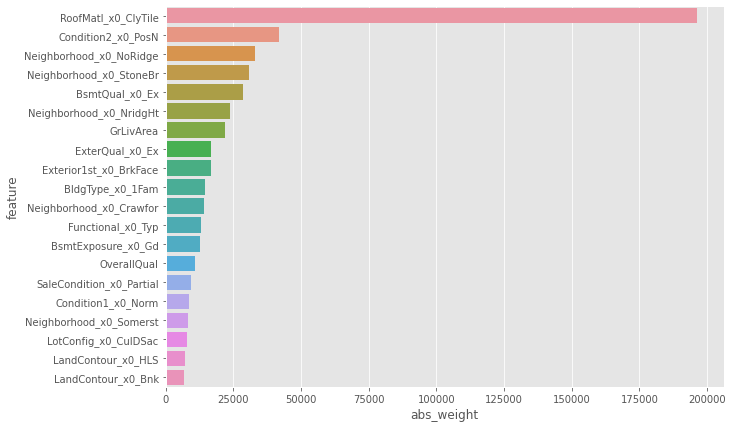

In [126]:
# the same but with stronger regularization
# (pay attention to absolute values of coefficients)

lasso = Lasso(alpha=200)
pipeline = Pipeline([('mapper', DataFrameMapper(features)), 
                     ('estimator', lasso)])

scores, colnames = evaluate_model(train_X, val_X, train_y, val_y, pipeline)
scores

plot_importance(pipeline.named_steps['estimator'], colnames)

##### Self-Exercise:
Show dependency between top 2 features (not encoded) and target variable.

<AxesSubplot:xlabel='RoofMatl', ylabel='SalePrice'>

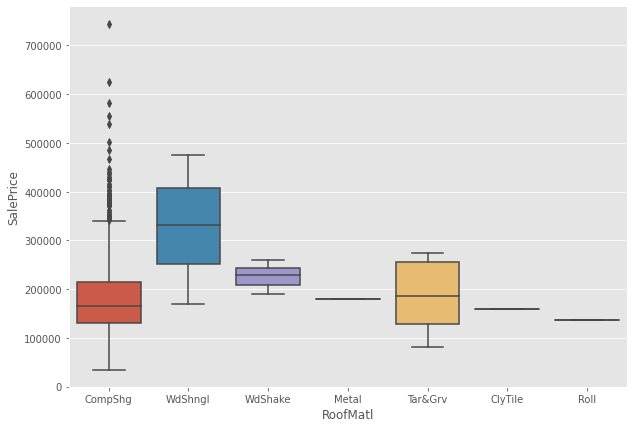

In [195]:
sns.boxplot(x="RoofMatl", y="SalePrice", data=train_X.assign(SalePrice = train_y))

##  Hyperparameters tuning

Cross validation

![alt text](https://alexforrest.github.io/images/cv.png)

Cross-validation is train/test split and metric computation done several times (usually 3-10 depending on data)

Time series split

![alt text](https://i.stack.imgur.com/fXZ6k.png)

In [127]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

pipeline = Pipeline([
    ('mapper', DataFrameMapper(features)),
    ('estimator', ElasticNet(random_state=SEED))
])

grid = {
    'estimator__alpha': np.linspace(0, 300, 10),
    'estimator__l1_ratio': np.arange(0, 1.1, 0.1)
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv)

In [128]:
%%time
gs.fit(train_X, train_y);

Wall time: 56.2 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('mapper',
                                        DataFrameMapper(drop_cols=[],
                                                        features=[(['LotFrontage'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()],
                                                                   {}),
                                                                  (['LotArea'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()],
                                                                   {}),
                                                                  (['MasVnrArea'],
                                             

In [129]:
gs.best_params_

{'estimator__alpha': 200.0, 'estimator__l1_ratio': 1.0}

In [130]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);

scores, col = evaluate_model(train_X, val_X, train_y, val_y, pipeline)
scores

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['LotFrontage'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()],
                                            {}),
                                           (['LotArea'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()],
                                            {}),
                                           (['MasVnrArea'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()],
                                            {}),
                                           (['BsmtFinSF1'],
                                            [SimpleImputer(strategy='median'),
                                 

,train_RMSE,train_R2,val_RMSE,val_R2
0,25358.652628,0.892186,30453.613681,0.879996


What will happen, if we use the same parameters, but log(y) for target?

Write the code evaluating model with best parameters. Try to explain results.

In [131]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);
scores, col = evaluate_model(train_X, val_X, train_y_tr, val_y_tr, pipeline)
scores

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['LotFrontage'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()],
                                            {}),
                                           (['LotArea'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()],
                                            {}),
                                           (['MasVnrArea'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()],
                                            {}),
                                           (['BsmtFinSF1'],
                                            [SimpleImputer(strategy='median'),
                                 

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.390441,0.0,0.432365,-0.007167


In [132]:
%%time
pipeline = clone(pipeline)
grid = {
    'estimator__alpha': np.linspace(0, 0.5, 10),
    'estimator__l1_ratio': np.arange(0, 0.5, 0.1)
}
gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error',
                  cv=cv, 
                  verbose=10)
gs.fit(train_X, np.log1p(train_y));

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Wall time: 28.6 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('mapper',
                                        DataFrameMapper(drop_cols=[],
                                                        features=[(['LotFrontage'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()],
                                                                   {}),
                                                                  (['LotArea'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()],
                                                                   {}),
                                                                  (['MasVnrArea'],
                                             

In [133]:
pipeline = gs.best_estimator_
scores, col = evaluate_model(train_X, val_X, train_y_tr, val_y_tr, 
                             pipeline)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.123588,0.899805,0.143521,0.889024
